In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH15-Agentic-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agentic-RAG


# News Letter Agent

## 도구 정의/설계
### 뉴스 검색

In [3]:
import os
from langchain_core.tools import tool
from tavily import TavilyClient

In [5]:
# TavilyClient 초기화 
tavily_client = TavilyClient()

In [6]:
def search_recent_news(keyword):
    """
    This tool interacts with the Tavily AI API to search for recent news articles related to a given keyword.

    Args:
        keyword (str): The keyword or phrase to search for in the news articles.

    Returns:
        list: 
        A list of titles, each containing up to 10 of the most recent news articles related to the keyword.
        - 'title' (str): The title of the news article.

    Example:
        response = search_news("OpenAI")
        # Returns a list of news articles published in the last day related to OpenAI.
    """
    article_info = []
    
    # Making the request to the Tavily API
    response = tavily_client.search(
        query=keyword, 
        max_results=10, 
        topic="news", 
        days=7
    )
    title_list = [i['title'] for i in response['results']]
    
    return title_list

In [7]:
keyword = "AI Agent"

In [8]:
result = search_recent_news(keyword)
print(result)

['ASU+GSV 2025: Uses for Agentic AI in Higher Education - GovTech', "Is the Tech Industry Ready for AI 'Super Agents'? - Business Insider", 'Miami AI Agent Summit, Co-Hosted by Miami AI Hub and CrewAI, Sells Out and Sets the Stage for the Future of Agentic AI - Reuters', "These agentic AI startups raised a combined $52 million. Here's a look at their decks — and what made them stand out. - Business Insider", 'DocJuris Unveils AI Email Agent for Contract Review, Negotiation Enterprise Legal Teams - Law.com', 'Amazon ‘Buy For Me’ Is The Latest Entrant In The AI Shopping Agent Race - Forbes', "First look: a16z's $20b fund, insect protein, and a Stada IPO - Axios", 'Microsoft Copilot AI Launch Interrupted by Pro-Palestinian Protesters - Variety', 'Devin, the viral coding AI agent, gets a new pay-as-you-go plan - TechCrunch', 'The Rise of M2M Marketing: Why SaaS Vendors Must Start Selling to Machines, Not Just Humans: By Jaco Fok - Finextra Research']


### 뉴스 테마 

In [15]:
from pydantic import BaseModel, Field
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [11]:
# 테마 정의 
class NewsletterThemeOutput(BaseModel):
    """Output model for structured theme and sub-theme generation."""

    theme: str = Field(
        description="The main newsletter theme based on the provided article titles."
    )
    sub_themes: list[str] = Field(
        description="List of sub-themes or key news items to investigate under the main theme, ensuring they are specific and researchable."
    )

In [12]:
# System Prompt
system = """
You are an expert helping to create a newsletter. 
Based on a list of article titles provided, your task is to choose a single, 
specific newsletter theme framed as a clear, detailed question that grabs the reader's attention. 

In addition, generate 5 sub-themes that are highly specific, researchable news items or insights under the main theme. 
Ensure these sub-themes reflect the latest trends in the field and frame them as compelling news topics.

The output should be formatted as:
- Main theme (in question form)
- 3-5 sub-themes (detailed and focused on emerging trends, technologies, or insights).

The sub-themes should create a clear direction for the newsletter, avoiding broad, generic topics.
All your output should be in Korean

"""

In [13]:
# Prompt Template 
theme_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Article titles: \n\n {article_titles}"),
    ]
)

# LLM with Tool
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_newsletter = llm.with_structured_output(NewsletterThemeOutput)

# Chain
newsletter_generator = theme_prompt | structured_llm_newsletter

In [14]:
output = newsletter_generator.invoke({"article_titles":result})
subthemes = output.sub_themes

print(subthemes)

['고등 교육에서 에이전틱 AI의 활용 사례: ASU+GSV 2025에서의 통찰', "AI '슈퍼 에이전트'의 등장: 기술 산업은 준비가 되었는가?", '마이애미 AI 에이전트 서밋: 에이전틱 AI의 미래를 위한 플랫폼', '에이전틱 AI 스타트업의 투자 동향: 5200만 달러의 자금 조달 사례 분석', 'AI 이메일 에이전트의 혁신: 계약 검토 및 협상에서의 활용']


In [16]:
# 뉴스 테마 함수 정의 
def subtheme_generator(recent_news: List[str]):
    
    # 뉴스 테마 정의 
    class NewsletterThemeOutput(BaseModel):
        """Output model for structured theme and sub-theme generation."""

        theme: str = Field(
            description="The main newsletter theme based on the provided article titles."
        )
        sub_themes: list[str] = Field(
            description="List of sub-themes or key news items to investigate under the main theme, ensuring they are specific and researchable."
        )

    # LLM with function call
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    structured_llm_newsletter = llm.with_structured_output(NewsletterThemeOutput)

    # System Prompt
    system = """
    You are an expert helping to create a newsletter. Based on a list of article titles provided, your task is to choose a single, 
    specific newsletter theme framed as a clear, detailed question that grabs the reader's attention. 

    In addition, generate 3 to 5 sub-themes that are highly specific, researchable news items or insights under the main theme. 
    Ensure these sub-themes reflect the latest trends in the field and frame them as compelling news topics.

    The output should be formatted as:
    - Main theme (in question form)
    - 3-5 sub-themes (detailed and focused on emerging trends, technologies, or insights).

    The sub-themes should create a clear direction for the newsletter, avoiding broad, generic topics.
    All your output should be in Korean

    """

    # Prompt Template 
    theme_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Article titles: \n\n {recent_news}"),
        ]
    )

    # Chain 
    subtheme_chain= theme_prompt | structured_llm_newsletter
    output = subtheme_chain.invoke({"recent_news":recent_news})
    
    return output

### 세부 뉴스 검색 (비동기)

In [18]:
import asyncio
from tavily import AsyncTavilyClient

In [19]:
# 비동기 클라이언트 초기화 
async_tavily_client = AsyncTavilyClient()

# 비동기 뉴스 검색 
# subtheme별로 Tavily API 검색 
async def search_news_for_subtheme(subtheme):
    response = await async_tavily_client.search(
        query=subtheme, 
        max_results=5, 
        topic="news", 
        days=7,
        include_images=True,     
        include_raw_content=True, 
    )

    # 각 기사에 맞는 제목, 이미지, 내용 추출
    images = response['images']
    results = response['results']
    
    article_info = []
    for i, result in enumerate(results):
        article_info.append({
            'title': result['title'],
            'image_url': images[i],
            'raw_content': result['raw_content']
        })
    
    return {subtheme: article_info}

# 여러 개의 subtheme에 대한 뉴스를 병렬 검색 
async def search_news_by_subthemes(subthemes):
    # asyncio.gather를 사용해 여러 비동기 작업 병렬 처리
    results = await asyncio.gather(*[search_news_for_subtheme(subtheme) for subtheme in subthemes])
    
    search_results = {}
    for result in results:
        search_results.update(result)
    
    return search_results

In [20]:
subtheme_search_results = await search_news_by_subthemes(subthemes)
print(subtheme_search_results)

{'고등 교육에서 에이전틱 AI의 활용 사례: ASU+GSV 2025에서의 통찰': [{'title': 'ASU+GSV 2025: Uses for Agentic AI in Higher Education - GovTech', 'image_url': 'https://erepublic.brightspotcdn.com/dims4/default/31c2a2f/2147483647/strip/true/crop/1348x655+0+28/resize/1440x700!/quality/90/?url=http://erepublic-brightspot.s3.amazonaws.com/45/c8/f6b0de4d4c02be23cf77ffc97b98/asugsv-summit-teusday.PNG', 'raw_content': "Published Time: April 07, 2025\nASU+GSV 2025: Uses for Agentic AI in Higher Education\nNews\nAnalytics\nArtificial Intelligence\nCivic Innovation\nCloud & Computing\nCybersecurity\nLohrmann on Cybersecurity\nEducation\nElection Technology\nEmerging Tech\nBudget & Finance\nInfrastructure\nGovernment Experience\nGovTech Biz\nBiz Data\nHealth & Human Services\nJustice & Public Safety\nBroadband & Network\nPolicy\nSmart Cities\nTransportation\nWorkforce & People\nVoices\nEvents\nWebinars\nPapers\nMagazine\nAbout\nAbout Us\nAdvertise\nNewsletters\nContact\nMore\nCenter for Digital Education\nCenter for 

### State 정의

In [24]:
from typing import Dict, List, TypedDict, Annotated
from langgraph.graph.message import add_messages

In [25]:
def merge_dicts(left: Dict, right: Dict) -> Dict:
    return {**left, **right}

In [26]:
class State(TypedDict):
    keyword: str
    article_titles: List[str]
    newsletter_theme: NewsletterThemeOutput
    sub_theme_articles: Dict[str, List[Dict]]
    results: Annotated[Dict[str, str], merge_dicts]
    messages: Annotated[List, add_messages]

### 본문 작성 Tool

In [27]:
from langchain_core.messages import HumanMessage, AIMessage

In [28]:
def write_newsletter_section(state: State, sub_theme: str) -> Dict:
    articles = state['sub_theme_articles'][sub_theme]
    
    # Prepare a list of formatted article 
    article_references = "\n".join(
        [f"Title: {article['title']}\nContent: {article['raw_content']}..."
         for article in articles]
    )
    
    prompt = f"""
    Write a newsletter section for the sub-theme: "{sub_theme}".
    
    Use the following articles as reference and include relevant points from both their titles, images, and content:
    <article>
    {article_references}
    <article/>
    Summarize the key points and trends related to this sub-theme, and ensure you reference the images where they add value to the discussion. 
    Keep the tone engaging and informative for newsletter readers. You should write in Korean
    """
    
    messages = [HumanMessage(content=prompt)]
    response = llm.invoke(messages)
    return {"results": {sub_theme: response.content}}


def write_newsletter_section(state: State, sub_theme: str) -> Dict:
    return asyncio.run(write_newsletter_section(state, sub_theme))

------------
## 함수 정의

In [29]:
import os
import operator
import asyncio
from typing import Dict, List, TypedDict, Annotated
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from tavily import TavilyClient

In [30]:
def merge_dicts(left: Dict, right: Dict) -> Dict:
    return {**left, **right}

class State(TypedDict):
    keyword: str
    article_titles: List[str]
    newsletter_theme: NewsletterThemeOutput
    sub_theme_articles: Dict[str, List[Dict]]
    results: Annotated[Dict[str, str], merge_dicts]
    messages: Annotated[List, add_messages]

# 동기 함수들
def search_keyword_news(state: State) -> State:
    keyword = state['keyword']
    article_titles = search_recent_news(keyword)
    return {"article_titles": article_titles}

def generate_newsletter_theme(state: State) -> State:
    article_titles = state['article_titles']
    newsletter_theme = newsletter_generator.invoke({"article_titles": "\n".join(article_titles)})
    newsletter_theme.sub_themes = newsletter_theme.sub_themes[:5]
    return {"newsletter_theme": newsletter_theme}

async def search_news_for_subtheme(subtheme):
    async_tavily_client = AsyncTavilyClient()
    response = await async_tavily_client.search(
        query=subtheme, 
        max_results=5, 
        topic="news", 
        days=1,
        include_images=True,
        include_raw_content=True
    )
    images = response['images']
    results = response['results']
    
    article_info = []
    for i, result in enumerate(results):
        article_info.append({
            'title': result['title'],
            'image_url': images[i],
            'raw_content': result['raw_content']
        })
    
    return {subtheme: article_info}

async def search_sub_theme_articles(state: State) -> State:
    subthemes = state['newsletter_theme'].sub_themes
    results = await asyncio.gather(*[search_news_for_subtheme(subtheme) for subtheme in subthemes])
    
    sub_theme_articles = {}
    for result in results:
        sub_theme_articles.update(result)
    
    return {"sub_theme_articles": sub_theme_articles}

async def write_newsletter_section_async(state: State, sub_theme: str) -> Dict:
    articles = state['sub_theme_articles'][sub_theme]
    
    # Prepare a list of formatted article references including title, image, and a snippet of raw content
    article_references = "\n".join(
        [f"Title: {article['title']}\nContent: {article['raw_content']}..."
         for article in articles]
    )
    
    prompt = f"""
    Write a newsletter section for the sub-theme: "{sub_theme}".
    
    Use the following articles as reference and include relevant points from both their titles, images, and content:
    <article>
    {article_references}
    <article/>
    Summarize the key points and trends related to this sub-theme, and ensure you reference the images where they add value to the discussion. 
    Keep the tone engaging and informative for newsletter readers. You should write in Korean
    """
    
    messages = [HumanMessage(content=prompt)]
    response = await llm.ainvoke(messages)
    return {"results": {sub_theme: response.content}}


def write_newsletter_section(state: State, sub_theme: str) -> Dict:
    return asyncio.run(write_newsletter_section_async(state, sub_theme))


def aggregate_results(state: State) -> State:
    theme = state['newsletter_theme'].theme
    combined_newsletter = f"# {theme}\n\n"
    for sub_theme, content in state['results'].items():
        combined_newsletter += f"## {sub_theme}\n{content}\n\n"
    return {"messages": [HumanMessage(content=f"Generated Newsletter:\n\n{combined_newsletter}")]}

def edit_newsletter(state: State) -> State:
    theme = state['newsletter_theme'].theme
    combined_newsletter = state['messages'][-1].content

    prompt = f"""
    As an expert editor, review and refine the following newsletter on the theme: {theme}

    {combined_newsletter}

    Please ensure:
    0. Title should be in question form. subtitles are free to make question or just sentence.
    1. Consistent tone and style throughout the newsletter
    2. Smooth transitions between sections
    3. Proper formatting and structure
    4. Clear and engaging language
    5. No grammatical or spelling errors

    Provide the edited version of the newsletter.
    """

    messages = [HumanMessage(content=prompt)]
    writer_llm = ChatOpenAI(model="gpt-4o-mini", temperature=1, max_tokens = 8192)
    response = writer_llm.invoke(messages)  # 'ainvoke'를 'invoke'로 변경
    
    return {"messages": [HumanMessage(content=f"Edited Newsletter:\n\n{response.content}")]}
    

## Graph 정의

In [31]:
workflow = StateGraph(State)

workflow.add_node("editor", edit_newsletter)
workflow.add_node("search_news", search_keyword_news)
workflow.add_node("generate_theme", generate_newsletter_theme)
workflow.add_node("search_sub_themes", search_sub_theme_articles)
workflow.add_node("aggregate", aggregate_results)

workflow.add_edge("aggregate", "editor")
workflow.add_edge("editor", END)

for i in range(5):
    node_name = f"write_section_{i}"
    workflow.add_node(node_name, lambda s, i=i: write_newsletter_section(s, s['newsletter_theme'].sub_themes[i]))

workflow.add_edge(START, "search_news")
workflow.add_edge("search_news", "generate_theme")
workflow.add_edge("generate_theme", "search_sub_themes")
for i in range(5):
    workflow.add_edge("search_sub_themes", f"write_section_{i}")
    workflow.add_edge(f"write_section_{i}", "aggregate")

graph = workflow.compile()

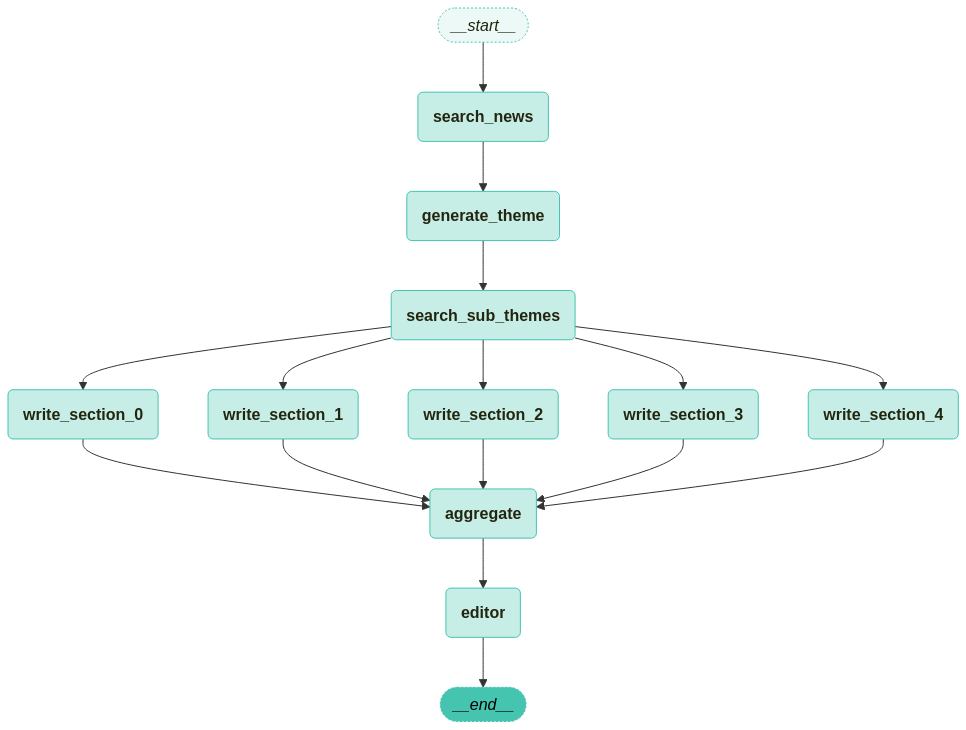

In [33]:
from langchain_teddynote.graphs import visualize_graph  

visualize_graph(graph)  

## Graph 실행 

In [ ]:
keyword = input("Enter a keyword for the newsletter: ")

In [34]:
inputs = {"keyword": keyword}

async for output in graph.astream(inputs, stream_mode="updates"):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(print(value))
    print("\n---\n")

Output from node 'search_news':
---
{'article_titles': ['ASU+GSV 2025: Uses for Agentic AI in Higher Education - GovTech', "Is the Tech Industry Ready for AI 'Super Agents'? - Business Insider", 'Miami AI Agent Summit, Co-Hosted by Miami AI Hub and CrewAI, Sells Out and Sets the Stage for the Future of Agentic AI - Reuters', "These agentic AI startups raised a combined $52 million. Here's a look at their decks — and what made them stand out. - Business Insider", 'DocJuris Unveils AI Email Agent for Contract Review, Negotiation Enterprise Legal Teams - Law.com', 'Amazon ‘Buy For Me’ Is The Latest Entrant In The AI Shopping Agent Race - Forbes', "First look: a16z's $20b fund, insect protein, and a Stada IPO - Axios", 'Microsoft Copilot AI Launch Interrupted by Pro-Palestinian Protesters - Variety', 'Devin, the viral coding AI agent, gets a new pay-as-you-go plan - TechCrunch', 'The Rise of M2M Marketing: Why SaaS Vendors Must Start Selling to Machines, Not Just Humans: By Jaco Fok - Fine

-----
** End of Documents **